# I. Module Imports and get data

In [ ]:
'''Import all necessary packages...pandas for data munging, 
sklearn's data preprocessing module, seaborn for data visualization
%matplotlib for making any plots show up inside of this notebook.
joblib for saving models (serialize/deserialize module). We will discuss
each of these packages as we use them for our analysis'''

import pandas as pd
from pandas.api.types import is_string_dtype,is_numeric_dtype
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier  # K-nearest neighbor algorithm
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score  # use to measure how good the model is
import joblib 

# two library for make visualization
from matplotlib import pyplot as plt 
import seaborn as sns

%matplotlib inline

In [ ]:
# download the csv file
import os
if(not os.path.exists('Titanic_full.csv')):
  !wget https://raw.githubusercontent.com/Taowyoo/LearningML/master/Module%203/Titanic_full.csv

--2020-10-05 23:57:54--  https://raw.githubusercontent.com/Taowyoo/LearningML/master/Module%203/Titanic_full.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91737 (90K) [text/plain]
Saving to: ‘Titanic_full.csv’

Titanic_full.csv    100%[===================>]  89.59K  --.-KB/s    in 0.03s   

2020-10-05 23:57:54 (2.89 MB/s) - ‘Titanic_full.csv’ saved [91737/91737]



In [ ]:
#Check the path to the directory where you are currently in
%pwd

'/content'

In [ ]:
'''Define a variable that points to current path. This will let you avoid typing
the long path everytime you need to use it'''

my_path = %pwd

In [ ]:
# mount google drive to store trained models and other files
# from google.colab import drive
# drive.mount('/content/drive')

# II. Reading data into the notebook

In [ ]:
'''We will use the Titanic dataset, as supplied here (Titanic_full.csv).
The same dataset can be downloaded from the Kaggle website. Check the
shape and header of the data you just read in as a dataframe. The use of
f and {} is specific to the recent versions of Python (3.x). You can as 
well type the full path here, and that works too!'''

my_df = pd.read_csv(f'{my_path}/Titanic_full.csv')
print(my_df.shape)
my_df.head(3)

(1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


# III. Train - Valid- Test Split

In [ ]:
'''As we have seen, it's important to avoid the Texas sharp shooter logical
fallacy. So, we plit the data into three sets in a 70-15-15 manner. 
This means 70% of the data rows go into building or training the model. 
This 70% is often called a training set. 15% of the data goes into 
evaluating model performance as you manually change or set the model 
hyperparameters (e.g. Value of K is a hyperparameter,in K-NN algorithm). 
This dataset is sometimes called a holdout set or the validation set. 
Finally, the last 15% of the data is the test set.  This dataset is 
never "seen" by the model for model building or hyperparamter tuning. After
hyperparameter tuning and model selection, which we will discuss later,
the model's final performance before sneidng it to production, will be
evalauted on this test data set.
The way the datarows are distributed will depend on the type of problem. 
Here, assuming the datarows of my_df are randomly arranged, and there's
no time component, we will simply simply do the split, using a split 
function that we define. Also, this 15% split 
for the test set may change, if the actual test set size is predefined. 
In any case we will make sure the test set we choose from our dataset 
is as similar as it can get to the actual data that it will see in 
production'''

#Calculate 15% of 1309. This is about 209 rows of data. 
#So, 1309 - 209 = 1100 rows of data will remain for the
#train and valid sets which we will separate later. 200 rows of data will
#go as test set data

def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]


mydf_train_valid,mydf_test = mydf_splitter(my_df,1100)

print(mydf_train_valid.shape,mydf_test.shape)

#We are going to put away the mydf_test for now. 
#We will return to it later.

(1100, 12) (209, 12)


# IV. Data Pre-processing

## 1) Pre-process data for validation and trainning

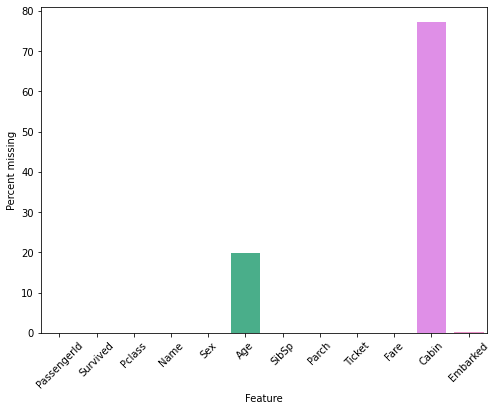

In [ ]:
''' Deal with missing values. First, calculate the percentage of
missing values for every column, and plot them as a bar chart'''

null_vals = mydf_train_valid.isnull().sum()/len(mydf_train_valid)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

From the above plot, it looks like Cabin has ~80%missing values.
It would be meaningless to impute or fill in 80% values, so we drop the column.
We will impute age (which has ~ 20% missing, but we'll try to impute),
Fare, and Embarked column.These have very little missing values

We are going to preprocess this dataset in these steps--

1. Convert the entire dataframe to an array of numbers. This itself is going to happen in two steps -- (a) Convert object types and string types to category type (b) map and convert cateogries of numbers.

2. Impute or "fill in" missing values or NaNs. Here, continuous (e.g. Fare column) and categorical values are treated separately. For filling up missing continuous values, we use the median value of that column, and filling up missing categorical values, we use 0. Also, we add a separate "marker" column for both that notes whether a value has been imputed or not.

3. Finally, for a lot of the algorithms like k-NN, we scale the data to lie between 0 and 1 with mean zero and unit variance.


In [ ]:
mydf_train_valid_2 = mydf_train_valid.drop("Cabin",axis = 'columns')
print(mydf_train_valid_2.shape)
mydf_train_valid_2.head(2)

(1100, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C


In [ ]:
#Check types of each column with the dataframe info () method
mydf_train_valid_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1100 non-null   int64  
 1   Survived     1100 non-null   int64  
 2   Pclass       1100 non-null   int64  
 3   Name         1100 non-null   object 
 4   Sex          1100 non-null   object 
 5   Age          881 non-null    float64
 6   SibSp        1100 non-null   int64  
 7   Parch        1100 non-null   int64  
 8   Ticket       1100 non-null   object 
 9   Fare         1099 non-null   float64
 10  Embarked     1098 non-null   object 
dtypes: float64(2), int64(5), object(4)
memory usage: 94.7+ KB


In [ ]:
'''You can see that several of the columns or features are "object" type
These need to be changed to category before we can convert those to 
mappings and numbers'''
#1 (a) Define a function to convert object types and string types to category type

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [ ]:
mydf_train_valid_3 = str_to_cat(mydf_train_valid_2)
print()

In [ ]:
#Check dtypes of columns after this operation
mydf_train_valid_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1100 non-null   int64   
 1   Survived     1100 non-null   int64   
 2   Pclass       1100 non-null   int64   
 3   Name         1100 non-null   category
 4   Sex          1100 non-null   category
 5   Age          881 non-null    float64 
 6   SibSp        1100 non-null   int64   
 7   Parch        1100 non-null   int64   
 8   Ticket       1100 non-null   category
 9   Fare         1099 non-null   float64 
 10  Embarked     1098 non-null   category
dtypes: category(4), float64(2), int64(5)
memory usage: 161.8 KB


In [ ]:
'''Check the cateogry mapping for Embarked and Sex column. We need this
later'''
print(mydf_train_valid_3.Embarked.cat.categories)
print(mydf_train_valid_3.Sex.cat.categories)

Index(['C', 'Q', 'S'], dtype='object')
Index(['female', 'male'], dtype='object')


All object categories like Name, Sex, and Ticket have been converted to
Category dtype !

In [ ]:
'''Define impute functions. Impute categorical NaNs with -1, 
where we add 1 to make it 0. For each 
continuous variables, we impute missing values with median values of that
column, and for every variable
where any rows were imputed, add a separate 'imputed or not' column'''

def mydf_to_nums(my_df, feature, null_status):
    """
    Parameters
    ----------
    my_df : source datafram
    feature : the series of 'feature'
    null_status : column name string
    """
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
#         print(f"convert {null_status} column categories to number")
#         print(my_df.head(20))
        
def mydf_imputer(my_df, feature, null_status, null_table):
    """
    Parameters
    ----------
    my_df : source datafram
    feature : the series of 'feature'
    null_status : column name string
    null_table : dict to store computed median
    """
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
#             print(f"process {null_status+'_na'}")
#             print(my_df.head(20))
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
#             print(f"fill NaN in {null_status} with median: {filler}")
#             print(my_df.head(20))
            null_table[null_status] = filler
#             print(f"put {null_status}:{filler} into null_table")
#             print(null_table)
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [ ]:
mydf_train_valid_4,my_table = mydf_preprocessor(mydf_train_valid_3,null_table = None)

In [ ]:
mydf_train_valid_4.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na,Fare_na
0,1,0,3,135,2,22.0,1,0,629,7.2500,3,False,False
1,2,1,1,245,1,38.0,1,0,713,71.2833,1,False,False
2,3,1,3,442,1,26.0,0,0,799,7.9250,3,False,False


In [ ]:
'''Please store the null_table, category mapping separately.
We will need to process the test dataset using these values'''
my_table

{'Age': 28.0, 'Fare': 14.4583}

In [ ]:
'''Now, let's separate the X and Y variables (vertical split of the 
dataframe). Here the Y column is the variable we are trying to predict, 
survived or not(0 = No, 1 = Yes)'''

Y = mydf_train_valid_4["Survived"]
X = mydf_train_valid_4.drop(["Survived"],axis = 1)

print(X.shape,Y.shape)

(1100, 12) (1100,)


In [ ]:
'''Note that the different continuous variable columns of this dataframe 
have numbers in different ranges. For example, the Fare and age columns. 
For some machine learning algorithms like Decision Trees and 
their ensembles (Random Forests, for example) the above X and Y
can be directly used as input. However, for a lot of other ML algorithms 
like K nearest neighbors (KNN), we need to scale the continuous variables 
so that their values are mapped to a number between 0 and 1. 
Let's split this dataframe into continuous variable 
columns and those with categorical variables. We will leave 
the categorical variables untouched because their 
values are treated as different levels and its kind of meaningless to
scale them'''

X_cat = X[['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Embarked', 'Age_na', 'Fare_na']]
X_con = X.drop(X_cat,axis = 1)
print(X_cat.shape,X_con.shape)

(1100, 10) (1100, 2)


In [ ]:
'''Scale the continuous variables. To standardize (includes scaling), 
we subtract mean of that column from every value, then divide the results 
by the variable's standard deviation. There are different ways to 
standardize. Please see preprocessing under scikit-leanr page'''

scaler = preprocessing.StandardScaler().fit(X_con)
X_con_sc = pd.DataFrame(scaler.transform(X_con))
X_con_sc.columns = ["Age","Fare"]
print(X_con_sc.shape)
X_con_sc.head(2)

(1100, 2)


,Age,Fare
0,-0.574896,-0.502155
1,0.659705,0.747957


In [ ]:
'''Store this scaler variable or its mean and SD, by pickling or something;
we need to use the same mean and SD scaler later while pre-processing 
the test set. Now, let's join the cateogrical and scaled continuous 
variables, back together into one dataframe'''

df_list = [X_cat,X_con_sc]
X_full = pd.concat(df_list,axis = 1)
print(X_full.shape)
X_full.head(2)

(1100, 12)


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
0,1,3,135,2,1,0,629,3,False,False,-0.574896,-0.502155
1,2,1,245,1,1,0,713,1,False,False,0.659705,0.747957


In [ ]:
'''Then, split into train and valid sets for model building 
and hyperparameter tuning, respectively !Remember, we need to 
split (horizontally the rows) X_full into train and validation sets.
We use the dataframe splitter function we defined previously.
Strictly for later use in another module, merge X and Y and store.
Save it as train data. Reason explained in module III'''

X_train,X_valid = mydf_splitter(X_full,900)
Y_train,Y_valid = mydf_splitter(Y,900)

print(X_train.shape,X_valid.shape,Y_train.shape,Y_valid.shape)


(900, 12) (200, 12) (900,) (200,)


In [ ]:
# creat a function to help show Plot confusion matrix easily
from sklearn.metrics import confusion_matrix

def showConfusionMat(Y_v, Y_p):
  to_show_mat = confusion_matrix(Y_v,Y_p)
  to_show_df = pd.DataFrame(to_show_mat)
  plt.figure(figsize = (8,8))
  sns.heatmap(to_show_df, xticklabels = ["Unlucky","Survived"],
              yticklabels = ["Unlucky","Survived"],annot = True)

In [ ]:
# create a function to help compute and show score
def calculateScore(Y_v, Y_p):
  acc = accuracy_score(Y_v,Y_p)
  matt_cor = matthews_corrcoef(Y_v,Y_p)
  f1 = f1_score(Y_v,Y_p)
  print(f'accuracy_score = {acc}')
  print(f'matthews_corrcoef = {matt_cor}')
  print(f'f1_score = {f1}')
  return acc, matt_cor, f1


## 2) Pre-process data for testing

In [ ]:
'''Before we can apply this on the test set, we
need to pre-process the test set in exactly the same way we did the
train_valid set !!!'''

print(mydf_test.shape)
mydf_test.head(3)


(209, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1100,1101,1,3,"Delalic, Mr. Redjo",male,25.0,0,0,349250,7.8958,NaN,S
1101,1102,0,3,"Andersen, Mr. Albert Karvin",male,32.0,0,0,C 4001,22.5250,NaN,S
1102,1103,1,3,"Finoli, Mr. Luigi",male,NaN,0,0,SOTON/O.Q. 3101308,7.0500,NaN,S


In [ ]:
#get rid of the "cabin" column as we did before with the train_valid set
mydf_test1 = mydf_test.drop("Cabin",axis = 1)
print(mydf_test1.shape)
mydf_test1.head(3)

(209, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
1100,1101,1,3,"Delalic, Mr. Redjo",male,25.0,0,0,349250,7.8958,S
1101,1102,0,3,"Andersen, Mr. Albert Karvin",male,32.0,0,0,C 4001,22.5250,S
1102,1103,1,3,"Finoli, Mr. Luigi",male,NaN,0,0,SOTON/O.Q. 3101308,7.0500,S


In [ ]:
'''Make sure the category codes for train and test sets are the same as 
the ones we used previously! Here, we have coded, Name, Sex, Ticket and 
embarked. Because Name and Ticket ids will not be repeated, 
we will check Sex and embarked. Checking category codes for the test set...'''

mydf_test2 = str_to_cat(mydf_test1)
mydf_test2.Sex.cat.categories

Index(['female', 'male'], dtype='object')

In [ ]:
#Check for the Embarked column
mydf_test2.Embarked.cat.categories

Index(['C', 'Q', 'S'], dtype='object')

In [ ]:
#Cool, this means the category codes are the same. We can proceed.
#Make sure you use the same impute values of median.
mydf_test3,my_table1 = mydf_preprocessor(mydf_test2,null_table = my_table)
print(mydf_test3.shape)
mydf_test3.head(3)

(209, 13)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na,Fare_na
1100,1101,1,3,47,2,25.0,0,0,106,7.8958,3,False,False
1101,1102,0,3,6,2,32.0,0,0,146,22.5250,3,False,False
1102,1103,1,3,62,2,28.0,0,0,187,7.0500,3,True,False


In [ ]:
my_table1

{'Age': 28.0, 'Fare': 14.4583}

In [ ]:
# Now, let's split out the X and Y variables (vertical split of the dataframe)
#Remember we did this previously!
Y_t = mydf_test3["Survived"]
X_t = mydf_test3.drop(["Survived"],axis = 1)


In [ ]:
#Separate continuous and categorical variables/columns for scaling

X_cat_t = X_t[['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Embarked', 'Age_na', 'Fare_na']]
X_con_t = X_t.drop(X_cat_t,axis = 1)
print(X_cat_t.shape,X_con_t.shape)

(209, 10) (209, 2)


In [ ]:
'''Scale using the training set mean and SD. This is already captured in
the scaler object we made. Else, save that in a joblib dump too to reload'''

X_con_sct = pd.DataFrame(scaler.transform(X_con_t))
X_con_sct.columns = ["Age","Fare"]
print(X_con_sct.shape)
X_con_sct.head(2)


(209, 2)


,Age,Fare
0,-0.343408,-0.489547
1,0.196729,-0.203944


In [ ]:
print(X_cat_t.shape,X_con_sct.shape)

(209, 10) (209, 2)


In [ ]:
#Re-index before merging
X_cat_t.reset_index(inplace = True,drop = False)

In [ ]:
X_cat_t.head()

,index,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na
0,1100,1101,3,47,2,0,0,106,3,False,False
1,1101,1102,3,6,2,0,0,146,3,False,False
2,1102,1103,3,62,2,0,0,187,3,True,False
3,1103,1104,2,45,2,0,0,179,3,False,False
4,1104,1105,2,91,1,1,0,38,3,False,False


In [ ]:
X_cat_t.drop("index",inplace = True,axis = 1)
X_cat_t.head(2)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na
0,1101,3,47,2,0,0,106,3,False,False
1,1102,3,6,2,0,0,146,3,False,False


In [ ]:
#Merge the two sets of columns
df_list_I = [X_cat_t,X_con_sct]
X_test_I = pd.concat(df_list_I,axis = 1)
print(X_test_I.shape)
X_test_I.head(2)

(209, 12)


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
0,1101,3,47,2,0,0,106,3,False,False,-0.343408,-0.489547
1,1102,3,6,2,0,0,146,3,False,False,0.196729,-0.203944


# V. Hyperparameters tuning with Grid Search

In [ ]:
# import module
from sklearn.model_selection import GridSearchCV
from time import time
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Utility function to report best scores and show in plot

def report(results, n_top=10):
    scores = []
    std = []
    rank = []
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print(f"Model with rank: {i},".format(i) 
            + "Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate])
            + "Parameters: {0}".format(results['params'][candidate]))
            scores.append(results['mean_test_score'][candidate])
            std.append(results['std_test_score'][candidate])
            rank.append(i)
    fig = plt.figure()
    plt.errorbar(rank, scores, yerr=std, label='mean score')
    plt.legend(loc='lower right')
    plt.show()

# create a classifier
grid_knn_model = KNeighborsClassifier()

# create parameter list
# do not use k=1, becuase it means use each row as itself, which is overfitting
param_grid = {'n_neighbors': range(2,201),
        'weights': ['uniform','distance'],
        'metric': ['euclidean','manhattan','chebyshev','minkowski','seuclidean']
        }
models_path = []
score_types = ['accuracy',
        'precision','precision_macro','precision_micro',
        'recall','recall_macro','recall_micro',
        'f1','f1_macro','f1_micro',
        'neg_brier_score']
grid_result_detail = []

GridSearchCV took 166.58 seconds for 1990 candidate parameter settings with accuracy score.
Model with rank: 1,Mean validation score: 0.659 (std: 0.032)Parameters: {'metric': 'chebyshev', 'n_neighbors': 21, 'weights': 'distance'}
Model with rank: 2,Mean validation score: 0.657 (std: 0.025)Parameters: {'metric': 'manhattan', 'n_neighbors': 50, 'weights': 'uniform'}
Model with rank: 2,Mean validation score: 0.657 (std: 0.027)Parameters: {'metric': 'chebyshev', 'n_neighbors': 28, 'weights': 'distance'}
Model with rank: 4,Mean validation score: 0.657 (std: 0.034)Parameters: {'metric': 'chebyshev', 'n_neighbors': 28, 'weights': 'uniform'}
Model with rank: 5,Mean validation score: 0.656 (std: 0.025)Parameters: {'metric': 'chebyshev', 'n_neighbors': 22, 'weights': 'distance'}
Model with rank: 5,Mean validation score: 0.656 (std: 0.024)Parameters: {'metric': 'chebyshev', 'n_neighbors': 27, 'weights': 'distance'}
Model with rank: 7,Mean validation score: 0.655 (std: 0.031)Parameters: {'metric':

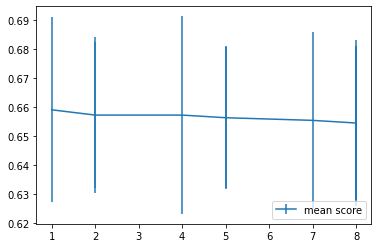

GridSearchCV took 178.34 seconds for 1990 candidate parameter settings with precision score.
Model with rank: 1,Mean validation score: 0.681 (std: 0.181)Parameters: {'metric': 'euclidean', 'n_neighbors': 57, 'weights': 'uniform'}
Model with rank: 1,Mean validation score: 0.681 (std: 0.181)Parameters: {'metric': 'minkowski', 'n_neighbors': 57, 'weights': 'uniform'}
Model with rank: 3,Mean validation score: 0.673 (std: 0.295)Parameters: {'metric': 'chebyshev', 'n_neighbors': 65, 'weights': 'uniform'}
Model with rank: 4,Mean validation score: 0.662 (std: 0.140)Parameters: {'metric': 'euclidean', 'n_neighbors': 55, 'weights': 'uniform'}
Model with rank: 4,Mean validation score: 0.662 (std: 0.140)Parameters: {'metric': 'minkowski', 'n_neighbors': 55, 'weights': 'uniform'}
Model with rank: 6,Mean validation score: 0.653 (std: 0.147)Parameters: {'metric': 'euclidean', 'n_neighbors': 54, 'weights': 'uniform'}
Model with rank: 6,Mean validation score: 0.653 (std: 0.147)Parameters: {'metric': 'm

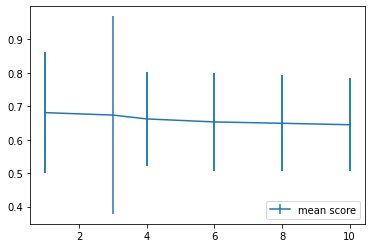

GridSearchCV took 176.47 seconds for 1990 candidate parameter settings with precision_macro score.
Model with rank: 1,Mean validation score: 0.671 (std: 0.086)Parameters: {'metric': 'euclidean', 'n_neighbors': 57, 'weights': 'uniform'}
Model with rank: 1,Mean validation score: 0.671 (std: 0.086)Parameters: {'metric': 'minkowski', 'n_neighbors': 57, 'weights': 'uniform'}
Model with rank: 3,Mean validation score: 0.663 (std: 0.067)Parameters: {'metric': 'euclidean', 'n_neighbors': 55, 'weights': 'uniform'}
Model with rank: 3,Mean validation score: 0.663 (std: 0.067)Parameters: {'metric': 'minkowski', 'n_neighbors': 55, 'weights': 'uniform'}
Model with rank: 5,Mean validation score: 0.662 (std: 0.150)Parameters: {'metric': 'chebyshev', 'n_neighbors': 65, 'weights': 'uniform'}
Model with rank: 6,Mean validation score: 0.661 (std: 0.062)Parameters: {'metric': 'chebyshev', 'n_neighbors': 28, 'weights': 'distance'}
Model with rank: 7,Mean validation score: 0.660 (std: 0.066)Parameters: {'metr

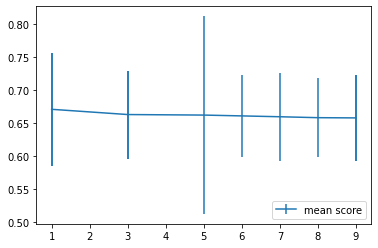

GridSearchCV took 170.88 seconds for 1990 candidate parameter settings with precision_micro score.
Model with rank: 1,Mean validation score: 0.659 (std: 0.032)Parameters: {'metric': 'chebyshev', 'n_neighbors': 21, 'weights': 'distance'}
Model with rank: 2,Mean validation score: 0.657 (std: 0.025)Parameters: {'metric': 'manhattan', 'n_neighbors': 50, 'weights': 'uniform'}
Model with rank: 2,Mean validation score: 0.657 (std: 0.027)Parameters: {'metric': 'chebyshev', 'n_neighbors': 28, 'weights': 'distance'}
Model with rank: 4,Mean validation score: 0.657 (std: 0.034)Parameters: {'metric': 'chebyshev', 'n_neighbors': 28, 'weights': 'uniform'}
Model with rank: 5,Mean validation score: 0.656 (std: 0.025)Parameters: {'metric': 'chebyshev', 'n_neighbors': 22, 'weights': 'distance'}
Model with rank: 5,Mean validation score: 0.656 (std: 0.024)Parameters: {'metric': 'chebyshev', 'n_neighbors': 27, 'weights': 'distance'}
Model with rank: 7,Mean validation score: 0.655 (std: 0.031)Parameters: {'m

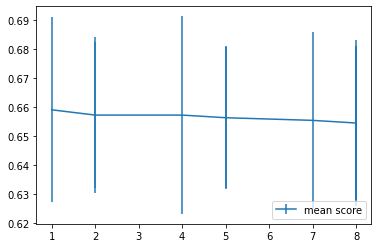

GridSearchCV took 173.15 seconds for 1990 candidate parameter settings with recall score.
Model with rank: 1,Mean validation score: 0.458 (std: 0.136)Parameters: {'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'distance'}
Model with rank: 2,Mean validation score: 0.457 (std: 0.138)Parameters: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
Model with rank: 2,Mean validation score: 0.457 (std: 0.138)Parameters: {'metric': 'minkowski', 'n_neighbors': 2, 'weights': 'distance'}
Model with rank: 4,Mean validation score: 0.457 (std: 0.170)Parameters: {'metric': 'chebyshev', 'n_neighbors': 3, 'weights': 'distance'}
Model with rank: 5,Mean validation score: 0.445 (std: 0.167)Parameters: {'metric': 'chebyshev', 'n_neighbors': 3, 'weights': 'uniform'}
Model with rank: 6,Mean validation score: 0.443 (std: 0.148)Parameters: {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}
Model with rank: 7,Mean validation score: 0.441 (std: 0.162)Parameters: {'metric': 'manha

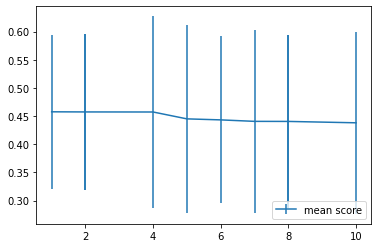

GridSearchCV took 170.71 seconds for 1990 candidate parameter settings with recall_macro score.
Model with rank: 1,Mean validation score: 0.598 (std: 0.052)Parameters: {'metric': 'chebyshev', 'n_neighbors': 21, 'weights': 'distance'}
Model with rank: 2,Mean validation score: 0.597 (std: 0.052)Parameters: {'metric': 'chebyshev', 'n_neighbors': 11, 'weights': 'uniform'}
Model with rank: 3,Mean validation score: 0.593 (std: 0.045)Parameters: {'metric': 'chebyshev', 'n_neighbors': 13, 'weights': 'uniform'}
Model with rank: 4,Mean validation score: 0.593 (std: 0.045)Parameters: {'metric': 'chebyshev', 'n_neighbors': 22, 'weights': 'distance'}
Model with rank: 5,Mean validation score: 0.591 (std: 0.042)Parameters: {'metric': 'chebyshev', 'n_neighbors': 12, 'weights': 'distance'}
Model with rank: 6,Mean validation score: 0.591 (std: 0.046)Parameters: {'metric': 'chebyshev', 'n_neighbors': 11, 'weights': 'distance'}
Model with rank: 7,Mean validation score: 0.590 (std: 0.052)Parameters: {'metr

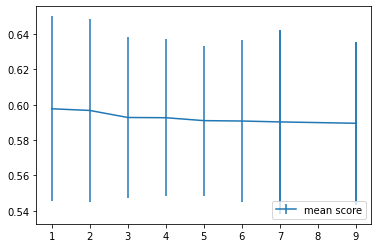

GridSearchCV took 169.73 seconds for 1990 candidate parameter settings with recall_micro score.
Model with rank: 1,Mean validation score: 0.659 (std: 0.032)Parameters: {'metric': 'chebyshev', 'n_neighbors': 21, 'weights': 'distance'}
Model with rank: 2,Mean validation score: 0.657 (std: 0.025)Parameters: {'metric': 'manhattan', 'n_neighbors': 50, 'weights': 'uniform'}
Model with rank: 2,Mean validation score: 0.657 (std: 0.027)Parameters: {'metric': 'chebyshev', 'n_neighbors': 28, 'weights': 'distance'}
Model with rank: 4,Mean validation score: 0.657 (std: 0.034)Parameters: {'metric': 'chebyshev', 'n_neighbors': 28, 'weights': 'uniform'}
Model with rank: 5,Mean validation score: 0.656 (std: 0.025)Parameters: {'metric': 'chebyshev', 'n_neighbors': 22, 'weights': 'distance'}
Model with rank: 5,Mean validation score: 0.656 (std: 0.024)Parameters: {'metric': 'chebyshev', 'n_neighbors': 27, 'weights': 'distance'}
Model with rank: 7,Mean validation score: 0.655 (std: 0.031)Parameters: {'metr

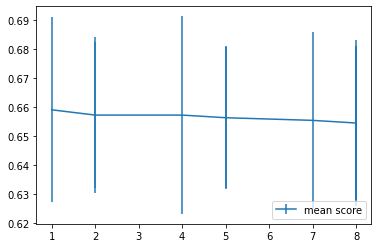

GridSearchCV took 168.59 seconds for 1990 candidate parameter settings with f1 score.
Model with rank: 1,Mean validation score: 0.442 (std: 0.080)Parameters: {'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'distance'}
Model with rank: 2,Mean validation score: 0.439 (std: 0.099)Parameters: {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}
Model with rank: 3,Mean validation score: 0.439 (std: 0.079)Parameters: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
Model with rank: 3,Mean validation score: 0.439 (std: 0.079)Parameters: {'metric': 'minkowski', 'n_neighbors': 2, 'weights': 'distance'}
Model with rank: 5,Mean validation score: 0.437 (std: 0.099)Parameters: {'metric': 'chebyshev', 'n_neighbors': 3, 'weights': 'distance'}
Model with rank: 6,Mean validation score: 0.436 (std: 0.114)Parameters: {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'distance'}
Model with rank: 6,Mean validation score: 0.436 (std: 0.114)Parameters: {'metric': 'minkowsk

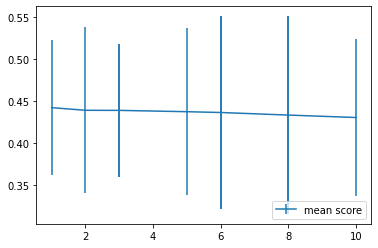

GridSearchCV took 170.90 seconds for 1990 candidate parameter settings with f1_macro score.
Model with rank: 1,Mean validation score: 0.585 (std: 0.070)Parameters: {'metric': 'chebyshev', 'n_neighbors': 11, 'weights': 'uniform'}
Model with rank: 2,Mean validation score: 0.579 (std: 0.080)Parameters: {'metric': 'chebyshev', 'n_neighbors': 21, 'weights': 'distance'}
Model with rank: 3,Mean validation score: 0.578 (std: 0.067)Parameters: {'metric': 'chebyshev', 'n_neighbors': 13, 'weights': 'uniform'}
Model with rank: 4,Mean validation score: 0.577 (std: 0.065)Parameters: {'metric': 'chebyshev', 'n_neighbors': 11, 'weights': 'distance'}
Model with rank: 5,Mean validation score: 0.577 (std: 0.064)Parameters: {'metric': 'chebyshev', 'n_neighbors': 12, 'weights': 'distance'}
Model with rank: 6,Mean validation score: 0.574 (std: 0.061)Parameters: {'metric': 'chebyshev', 'n_neighbors': 15, 'weights': 'uniform'}
Model with rank: 7,Mean validation score: 0.573 (std: 0.063)Parameters: {'metric': 

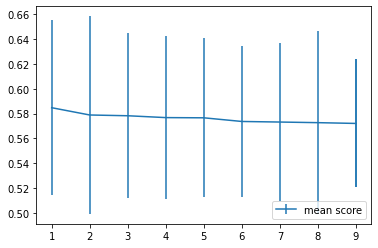

GridSearchCV took 170.14 seconds for 1990 candidate parameter settings with f1_micro score.
Model with rank: 1,Mean validation score: 0.659 (std: 0.032)Parameters: {'metric': 'chebyshev', 'n_neighbors': 21, 'weights': 'distance'}
Model with rank: 2,Mean validation score: 0.657 (std: 0.025)Parameters: {'metric': 'manhattan', 'n_neighbors': 50, 'weights': 'uniform'}
Model with rank: 2,Mean validation score: 0.657 (std: 0.027)Parameters: {'metric': 'chebyshev', 'n_neighbors': 28, 'weights': 'distance'}
Model with rank: 4,Mean validation score: 0.657 (std: 0.034)Parameters: {'metric': 'chebyshev', 'n_neighbors': 28, 'weights': 'uniform'}
Model with rank: 5,Mean validation score: 0.656 (std: 0.025)Parameters: {'metric': 'chebyshev', 'n_neighbors': 22, 'weights': 'distance'}
Model with rank: 5,Mean validation score: 0.656 (std: 0.024)Parameters: {'metric': 'chebyshev', 'n_neighbors': 27, 'weights': 'distance'}
Model with rank: 7,Mean validation score: 0.655 (std: 0.031)Parameters: {'metric':

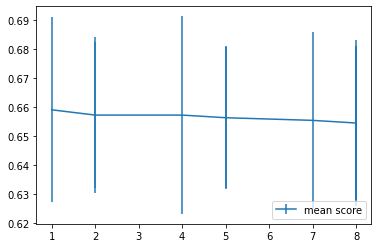

GridSearchCV took 145.15 seconds for 1990 candidate parameter settings with neg_brier_score score.
Model with rank: 1,Mean validation score: -0.222 (std: 0.012)Parameters: {'metric': 'chebyshev', 'n_neighbors': 38, 'weights': 'distance'}
Model with rank: 2,Mean validation score: -0.222 (std: 0.016)Parameters: {'metric': 'chebyshev', 'n_neighbors': 18, 'weights': 'uniform'}
Model with rank: 3,Mean validation score: -0.222 (std: 0.012)Parameters: {'metric': 'chebyshev', 'n_neighbors': 38, 'weights': 'uniform'}
Model with rank: 4,Mean validation score: -0.222 (std: 0.012)Parameters: {'metric': 'chebyshev', 'n_neighbors': 31, 'weights': 'uniform'}
Model with rank: 5,Mean validation score: -0.222 (std: 0.012)Parameters: {'metric': 'chebyshev', 'n_neighbors': 39, 'weights': 'distance'}
Model with rank: 6,Mean validation score: -0.222 (std: 0.014)Parameters: {'metric': 'euclidean', 'n_neighbors': 48, 'weights': 'distance'}
Model with rank: 6,Mean validation score: -0.222 (std: 0.014)Parameter

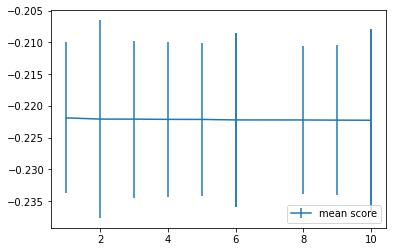

Result models:
['/content/knn_model/knn_accuracy.sav', '/content/knn_model/knn_precision.sav', '/content/knn_model/knn_precision_macro.sav', '/content/knn_model/knn_precision_micro.sav', '/content/knn_model/knn_recall.sav', '/content/knn_model/knn_recall_macro.sav', '/content/knn_model/knn_recall_micro.sav', '/content/knn_model/knn_f1.sav', '/content/knn_model/knn_f1_macro.sav', '/content/knn_model/knn_f1_micro.sav', '/content/knn_model/knn_neg_brier_score.sav']


In [42]:
# get all best models according to different scoring methods
for score in score_types:
  grid_search = GridSearchCV(grid_knn_model,param_grid=param_grid,scoring=score,n_jobs=-1,cv=10)
  start = time()
  grid_search.fit(X_full,Y)
  print("GridSearchCV took %.2f seconds for %d candidate parameter settings with %s score."
        % (time() - start, len(grid_search.cv_results_['params']), score))
  report(grid_search.cv_results_)
  # save result
  grid_result_detail.append(grid_search.cv_results_)

  # create model with best parameter
  knn_model_fin = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'],
                      weights=grid_search.best_params_['weights'],
                      metric=grid_search.best_params_['metric'])
  # train with data for train and valid
  knn_model_fin.fit(X_full,Y)
  # store trained model
  if not os.path.exists('knn_model'):
    !mkdir knn_model
  knn_model_fin_path = f'{my_path}/knn_model/knn_{score}.sav'
  models_path.append(knn_model_fin_path)
  joblib.dump(knn_model_fin,knn_model_fin_path)

print("Result models:")
print(models_path)

In [44]:
# save grid search detailed info
if not os.path.exists('grid_result_detail'):
      !mkdir grid_result_detail
grid_result_detail_path = f'{my_path}/grid_result_detail/grid_result_detail.data'
joblib.dump(grid_result_detail,grid_result_detail_path)

['/content/grid_result_detail/grid_result_detail.data']

# VI. Evaluating test set accuracy with the trained model

In [45]:
# test all best models according to different scoring methods
score_acc = []
for method,path in zip(score_types,models_path):
  kNN_loaded = joblib.load(path)
  Y_test_pred = kNN_loaded.predict(X_test_I)
  print(f"Testing best model scoring by {method}")
  print("Parameters: ",kNN_loaded.get_params())
  score_acc.append(accuracy_score(Y_t,Y_test_pred))
  print(accuracy_score(Y_t,Y_test_pred),
        matthews_corrcoef(Y_t,Y_test_pred),f1_score(Y_t,Y_test_pred))
  

Testing best model scoring by accuracy
Parameters:  {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'chebyshev', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 21, 'p': 2, 'weights': 'distance'}
0.5645933014354066 0.0 0.0
Testing best model scoring by precision
Parameters:  {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 57, 'p': 2, 'weights': 'uniform'}
0.5502392344497608 -0.05620276865888246 0.040816326530612256
Testing best model scoring by precision_macro
Parameters:  {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 57, 'p': 2, 'weights': 'uniform'}
0.5502392344497608 -0.05620276865888246 0.040816326530612256
Testing best model scoring by precision_micro
Parameters:  {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'chebyshev', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 21, 'p': 2, 'weights': 'distance'}
0.5645933014354066 0.0 0.0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classific

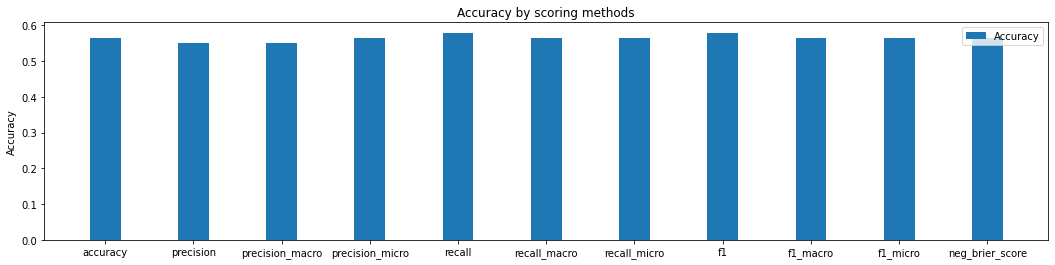

In [46]:
# show plot of different accuracy by scoring methods
labels = score_types
values = score_acc
width = 0.35  # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, values, width, label='Accuracy')

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by scoring methods')
fig.set_figwidth(18)
ax.legend()

plt.show()

## Summary of trainning

- The best training model is model with following paramenters, of which accuracy is about 57.8947% a liitle bit bigger than the model with k=14 which is selected by simply using loop for tunning

```python
{
  'algorithm': 'auto',
  'leaf_size': 30,
  'metric': 'manhattan',
  'metric_params': None,
  'n_jobs': None,
  'n_neighbors': 2,
  'p': 2,
  'weights': 'distance'
}
```

- In short, after detailed grid search, no result trainning model represent good prediction on Test set.

- The K_NN algorithm performs bad on this problem.



In [48]:
'''Write out full train_valid and test dataframes for later use
in module III'''
X_full["Survived"] = Y
X_test_I["Survived"] = Y_t

print(X_full.shape)
print(X_test_I.shape)

(1100, 13)
(209, 13)


# VII. The disadvantages of k-NN algorithm


From above traing and testing results, I could sum up following disadvantages of KNN algorithm:

1.   To K-NN, it's difficult to treat different meaning value properly. As the input data contains different kind of values such as the data of Titanic: some of data is real number and others are boolean or integer, when training we all treat them as real-number by choosing those metics specially for real number, so it might cause the model treat the data in wrong way and lose valuable  info.

  In another word, we might create our custom metric to deal with data, but there seems no reliable reference or ideas for design our custom metric.

2.   After looking carefully to the trained model, all ways of training cannot givs us great prediction. So K-NN seems not suit to this problem.

3.   Sometimes, K-NN is easy to be overfitting. According to some of trained model, the prediction are simply all 0, which meaning that the test case cantains more  not survived people, which is not we exactly want.

